In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [6]:

from dataclasses import replace
from pathlib import Path
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, cdist
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

from src.analysis.state_space import prepare_state_trajectory, StateSpaceAnalysisSpec
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.models import get_best_checkpoint
from src.models.integrator import ContrastiveEmbeddingModel, compute_embeddings, load_or_compute_embeddings

ImportError: cannot import name 'load_or_compute_embeddings' from 'src.models.integrator' (/Users/jon/Projects/ideal-word-representations/src/models/integrator.py)

In [ ]:
model_dir = "outputs/models/w2v2_32/phoneme_within_word_prefix"
# equiv_dataset_path = "../data/timit_equiv_phoneme_within_word_prefix_1.pkl"
# model_checkpoint = "../out/ce_model_phoneme_6_32/checkpoint-800/"
equiv_dataset_path = "data/timit_equiv_phoneme_6_1.pkl"
output_dir = "."

state_space_spec_path = "out/state_space_specs/all_phonemes_by_identity.pkl"

metric = "cosine"

In [21]:
model = ContrastiveEmbeddingModel.from_pretrained(get_best_checkpoint(model_dir))
model.eval()

ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=32, bias=True)
  )
)

In [3]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = pickle.load(f)

NameError: name 'equiv_dataset_path' is not defined

In [4]:
with open(state_space_spec_path, "rb") as f:
    state_space_spec: StateSpaceAnalysisSpec = pickle.load(f)
assert state_space_spec.is_compatible_with(equiv_dataset)

NameError: name 'state_space_spec_path' is not defined

In [24]:
model_representations = load_or_compute_embeddings(model, equiv_dataset, model_dir, equiv_dataset_path)

  0%|          | 0/44135 [00:00<?, ?it/s]

In [25]:
pca = PCA(n_components=2)
model_representations_pca = pca.fit_transform(model_representations)

In [26]:
# Retain only phonemes with N or more instances
retain_n = 3
retain_idxs = [idx for idx, target_frames in enumerate(state_space_spec.target_frame_spans)
               if len(target_frames) >= retain_n]
state_space_spec = replace(state_space_spec,
    labels=[state_space_spec.labels[i] for i in retain_idxs],
    target_frame_spans=[state_space_spec.target_frame_spans[i] for i in retain_idxs],
)

In [27]:
trajectory = prepare_state_trajectory(model_representations, state_space_spec)

In [28]:
len(trajectory)

40

In [29]:
def get_mean_distance(samp1, samp2, metric=None):
    distances = cdist(samp1, samp2, metric=metric)
    distances = np.triu(distances, k=1)
    return distances[distances != 0].mean()

## Estimate within-word distance

In [30]:
max_num_instances = 50
within_distance = np.zeros((len(trajectory), trajectory[0].shape[1]))
for i, trajectory_i in enumerate(tqdm(trajectory)):
    within_distance_i = []
    num_instances, num_frames, num_dims = trajectory_i.shape

    num_instances_limited = min(num_instances, max_num_instances)
    samples_i = trajectory_i[np.random.choice(num_instances, size=num_instances_limited, replace=False)]
    for j in range(num_frames):
        within_distance[i, j] = get_mean_distance(samples_i[:, j, :], samples_i[:, j, :], metric=metric)

  0%|          | 0/40 [00:00<?, ?it/s]

<Axes: >

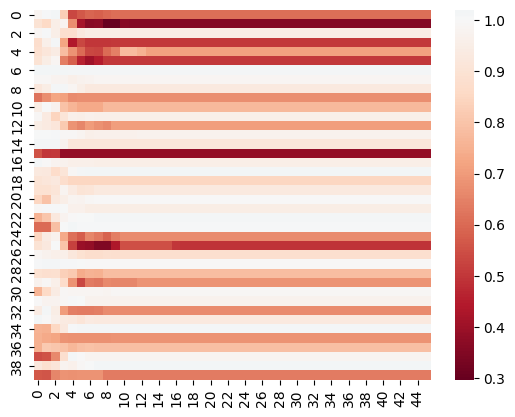

In [31]:
sns.heatmap(within_distance, center=1, cmap="RdBu")

In [32]:
within_distance_df = pd.DataFrame(within_distance, index=pd.Index(state_space_spec.labels, name="word")) \
    .reset_index() \
    .melt(id_vars=["word"], var_name="frame", value_name="distance")

<Axes: xlabel='frame', ylabel='distance'>

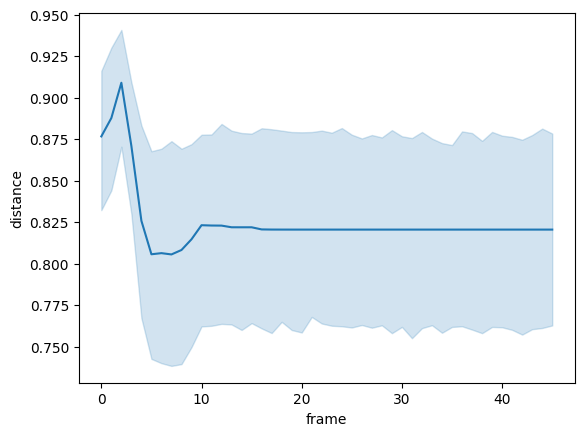

In [33]:
sns.lineplot(data=within_distance_df, x="frame", y="distance")

## Estimate between-phoneme distance

In [34]:
num_samples = min(len(trajectory) - 1, 50)
max_num_instances = 50
between_samples = [np.random.choice(list(range(idx)) + list(range(idx + 1, len(trajectory))),
                                    num_samples, replace=False)
                   for idx in range(len(trajectory))]
between_distances = np.zeros((len(trajectory), trajectory[0].shape[1], num_samples))
for i, between_samples_i in enumerate(tqdm(between_samples)):
    traj_i = trajectory[i]
    if traj_i.shape[0] > max_num_instances:
        traj_i = traj_i[np.random.choice(traj_i.shape[0], size=max_num_instances, replace=False)]
    
    for j, between_sample in enumerate(between_samples_i):
        traj_j = trajectory[between_sample]
        if traj_j.shape[0] > max_num_instances:
            traj_j = traj_j[np.random.choice(traj_j.shape[0], size=max_num_instances, replace=False)]
        
        for k in range(trajectory[0].shape[1]):
            between_distances[i, k, j] = get_mean_distance(traj_i[:, k, :], traj_j[:, k, :], metric=metric).mean()

  0%|          | 0/40 [00:00<?, ?it/s]

In [35]:
between_distances_df = pd.DataFrame(between_distances.mean(axis=-1),
                                    index=pd.Index(state_space_spec.labels, name="word")) \
    .reset_index() \
    .melt(id_vars=["word"], var_name="frame", value_name="distance")

<Axes: xlabel='frame', ylabel='distance'>

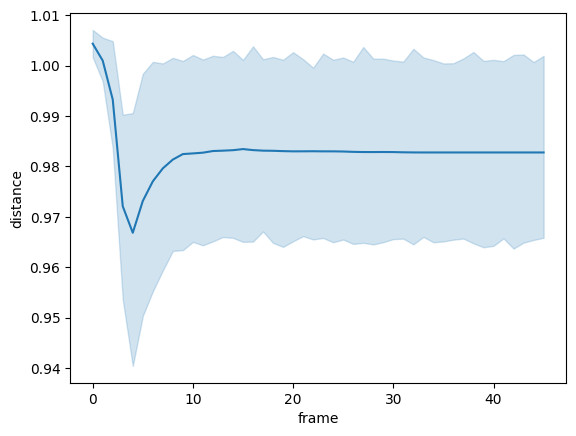

In [36]:
sns.lineplot(data=between_distances_df, x="frame", y="distance")

## Together

In [39]:
merged_df = pd.concat([within_distance_df.assign(type="within"), between_distances_df.assign(type="between")])
merged_df.to_csv(Path(output_dir) / "distances.csv", index=False)
merged_df

,word,frame,distance,type
0,AA,0,0.981935,within
1,AE,0,0.899264,within
2,AH,0,0.987294,within
3,AO,0,0.874135,within
4,AW,0,0.888029,within
...,...,...,...,...
1835,W,45,1.054750,between
1836,Y,45,1.108357,between
1837,Z,45,1.015022,between
1838,ZH,45,0.970987,between


Text(0, 0.5, 'Cosine distance')

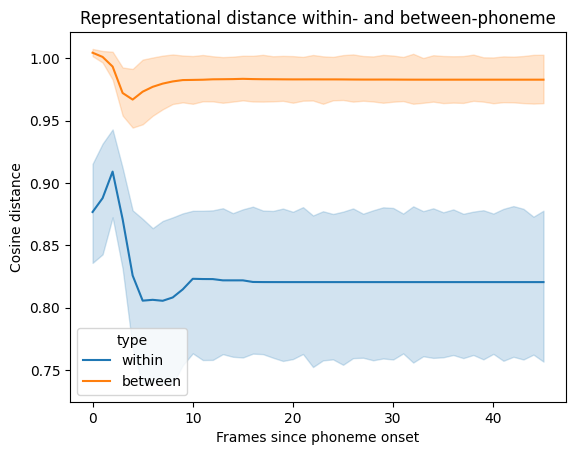

In [40]:
ax = sns.lineplot(data=merged_df, x="frame", y="distance", hue="type")
ax.set_title("Representational distance within- and between-phoneme")
ax.set_xlabel("Frames since phoneme onset")
ax.set_ylabel(f"{metric.capitalize()} distance")

## Block by phoneme categories

In [41]:
phoneme_categorizations = {
    "cv": {
        "consonant": "B CH D DH F G HH JH K L M N NG P R S SH T TH V W Y Z ZH".split(" "),
        "vowel": "AA AE AH AO AW AY EH ER EY IH IY OW OY UH UW".split(" "),
    }
}

In [42]:
for name, categorization in tqdm(phoneme_categorizations.items()):
    for phoneme_list in categorization.values():
        for phoneme in phoneme_list:
            assert phoneme in state_space_spec.labels, f"Phoneme {phoneme} missing from state space spec"

    # Prepare balanced sample of representations for each phoneme in each category
    min_instances = min(len(state_space_spec.target_frame_spans[i]) for i in range(len(state_space_spec.labels)))

  0%|          | 0/1 [00:00<?, ?it/s]